### Processing CIR


Color infrared (CIR) imagery, also known as false-color imagery, the near-infrared (NIR) band is typically assigned to a channel that would ordinarily represent red in true-color imagery. This means that the red, green, and blue (RGB) channels are shifted in the NIR photographs. The NIR band is used instead of the red band, the red band shifts to the place of the green band, and the green band moves to the blue band's position. 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, json, pickle
sys.path.append('../scripts/')
import rasterio
import random
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

import create_patches_from_polygons_data as cpd
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import loadpaths 

path_dict = loadpaths.loadpaths()  # load paths (see content/README_datapaths.md)

/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resize raster

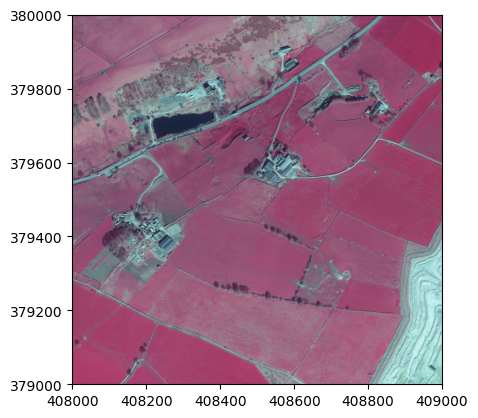

<Axes: >

In [13]:
src = rasterio.open("/home/david/Documents/ADP/50cm Colour Infrared/SK0879.tif") 
show(src)

In [14]:
# Accessing raster details
print("Raster width in pixels:", src.width)
print("Raster height in pixels:", src.height)
print("Number of bands:", src.count)
print("Data type of each band:", src.dtypes)

Raster width in pixels: 2000
Raster height in pixels: 2000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


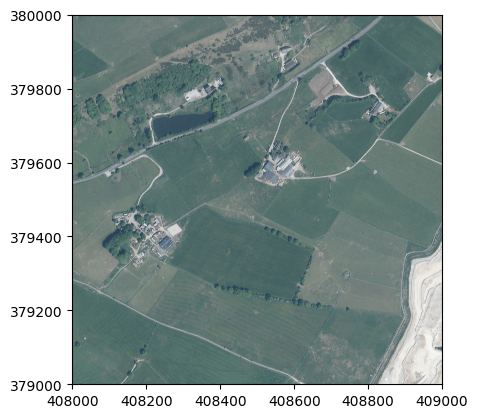

<Axes: >

In [18]:
from rasterio.plot import show
rgb = rasterio.open("/home/david/Documents/ADP/RGB_12.5cm/SK0879.tif)"
show(rgb)

In [19]:
# Accessing raster details
print("Raster width in pixels:", rgb.width)
print("Raster height in pixels:", rgb.height)
print("Number of bands:", rgb.count)
print("Data type of each band:", rgb.dtypes)

Raster width in pixels: 8000
Raster height in pixels: 8000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


## Resizing using bilinear interpolation 

In [21]:
from rasterio.enums import Resampling

# Open the color infrared raster file
src = rasterio.open("/home/david/Documents/ADP/50cm Colour Infrared/SK0879.tif")

# Target dimensions
target_width = 8000
target_height = 8000

# Resampling method
resampling_method = Resampling.bilinear

# Compute the scale factors for resizing
scale_x = target_width / src.width
scale_y = target_height / src.height

# Perform the resizing
data = src.read(
    out_shape=(src.count, target_height, target_width),
    resampling=resampling_method
)

# Update the metadata for the resized raster
transform = src.transform * src.transform.scale(
    (src.width / target_width),
    (src.height / target_height)
)

# Update the width and height
new_width, new_height = target_width, target_height

# Update the src profile
profile = src.profile
profile.update(width=new_width, height=new_height, transform=transform)

# Save or process the resized data
# For example, you can save it to a new raster file
with rasterio.open("/home/david/Documents/ADP/test/resized_cir_image.tif", "w", **profile) as dst:
    dst.write(data)

# Close the source raster
src.close()

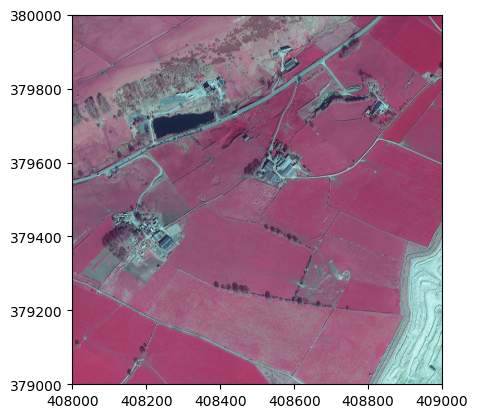

<Axes: >

In [22]:
from rasterio.plot import show
cir_resize = rasterio.open("/home/david/Documents/ADP/test/resized_cir_image.tif")
show(cir_resize)

In [23]:
# Accessing raster details
print("Raster width in pixels:", cir_resize.width)
print("Raster height in pixels:", cir_resize.height)
print("Number of bands:", cir_resize.count)
print("Data type of each band:", cir_resize.dtypes)

Raster width in pixels: 8000
Raster height in pixels: 8000
Number of bands: 3
Data type of each band: ('uint8', 'uint8', 'uint8')


## Batch process the 80 train and test tiles

In [26]:
# Define source and target directories
source_dir = "/home/david/Documents/ADP/50cm Colour Infrared/"
target_dir = "/home/david/Documents/ADP/CIR_12.5cm/"

# Target dimensions
target_width = 8000
target_height = 8000

# Resampling method
resampling_method = Resampling.bilinear

# Iterate over each file in the source directory
for filename in os.listdir(source_dir):
    # Check if the file is a TIFF file
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        # Open the source raster file
        src_path = os.path.join(source_dir, filename)
        src = rasterio.open(src_path)

        # Compute the scale factors for resizing
        scale_x = target_width / src.width
        scale_y = target_height / src.height

        # Perform the resizing
        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=resampling_method
        )

        # Update the metadata for the resized raster
        transform = src.transform * src.transform.scale(
            (src.width / target_width),
            (src.height / target_height)
        )

        # Update the width and height
        new_width, new_height = target_width, target_height

        # Update the src profile
        profile = src.profile
        profile.update(width=new_width, height=new_height, transform=transform)

        # Construct the target file path
        target_path = os.path.join(target_dir, filename)

        # Save the resized image to the target directory
        with rasterio.open(target_path, "w", **profile) as dst:
            dst.write(data)

        # Close the source raster
        src.close()

print("Resizing completed.")

Resizing completed.


## 4 Band Ratser Test

In [2]:
rgb_path = "/home/david/Documents/ADP/RGB_12.5cm/"
cir_path = "/home/david/Documents/ADP/CIR_12.5cm/"
output_path = "/home/david/Documents/ADP/4band_12.5cm/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Loop through the files in the RGB directory
for filename in os.listdir(rgb_path):
    if filename.endswith(".tif"):  # Assuming .tif format
        rgb_file = os.path.join(rgb_path, filename)
        cir_file = os.path.join(cir_path, filename)
        output_file = os.path.join(output_path, filename)

        # Open the RGB and NIR (CIR) files
        with rasterio.open(rgb_file) as rgb_src, rasterio.open(cir_file) as cir_src:
            # Read the RGB bands
            rgb = rgb_src.read([1, 2, 3])  # Read first three bands for RGB

            # Assuming the NIR band is the first band in the CIR file ### I need to check this (DA)
            nir = cir_src.read(1)

            # Stack the NIR band with RGB bands
            four_band_image = np.vstack((rgb, nir[np.newaxis, :, :]))

            # Define the new dataset's profile (copy from the RGB and modify) this correct tvdplas?
            out_profile = rgb_src.profile
            out_profile.update({
                "count": 4  # Number of bands
            })

            # Write the new 4-band raster file
            with rasterio.open(output_file, 'w', **out_profile) as dst:
                dst.write(four_band_image)

### Prepare the 4band Ratser for the model

In [ ]:
# use function to create the training data
cpd.main(
    path_image_tile_tifs="/home/david/Documents/ADP/4band_12.5cm/",
    path_tile_outline_shp='../content/evaluation_sample_50tiles/eval_all_tile_outlines/eval_all_tile_outlines.shp',
    save_dir_mask_tifs='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/',
    path_lc='../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override_clip.shp',
    dir_im_save_patches='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/',
    dir_mask_save_patches='/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/',
    create_patches=True,
    create_mask_tiles=True,
    save_im_patches=True,
    tif_ims_in_subdirs=False,
    discard_empty_patches=True,
    suffix_name='_lc_2022_detailed_mask'
)

In [ ]:
# remove the extra patches manually. Not sure why it creates 527 extra patches
def list_files(directory):
    """Returns a list of files in the given directory."""
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def delete_extra_files(image_dir, mask_dir, extra_files):
    """Delete specified files from both image and mask directories."""
    for filename in extra_files:
        image_path = os.path.join(image_dir, filename)
        mask_filename = filename.replace('.npy', '_lc_2022_detailed_mask.npy')  # Adjust the suffix if necessary
        mask_path = os.path.join(mask_dir, mask_filename)

        # Check if files exist and then delete
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted {image_path}")
        if os.path.exists(mask_path):
            os.remove(mask_path)
            print(f"Deleted {mask_path}")

def compare_and_cleanup(image_dir, mask_dir):
    reference_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format/images_python_all/'
    
    # Files in the new and reference directories
    image_files_new = set(list_files(image_dir))
    image_files_ref = set(list_files(reference_dir))
    
    # Files only in the new directory
    extra_files = list(image_files_new - image_files_ref)
    print(f"Files only in {image_dir}: {len(extra_files)}")

    # Display extra files and delete them
    if extra_files:
        print("Extra files to be deleted:")
        for file in extra_files:
            print(file)
        delete_extra_files(image_dir, mask_dir, extra_files)
    else:
        print("No extra files to delete.")

# Directory paths
image_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/'
mask_dir = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/'

# Compare directories and clean up
compare_and_cleanup(image_dir, mask_dir)

Shape of original RGB image: (3, 512, 512)
Shape of 4-band image: (4, 512, 512)
RGB values from original image: [79 77 78]
RGB values from 4-band image: [79 77 78 64]


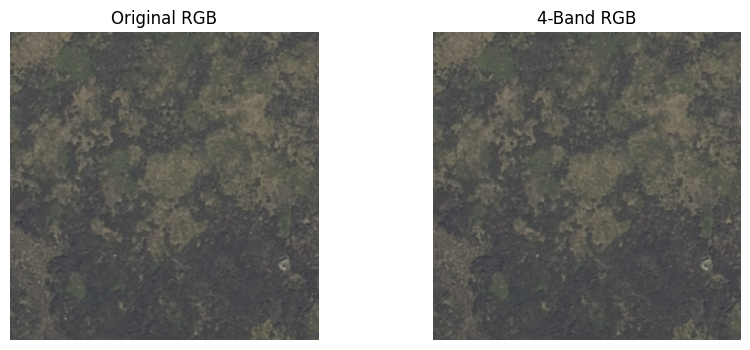

In [31]:
def load_and_compare(image_path_rgb, image_path_4band, position):
    # Load the images
    rgb_image = np.load(image_path_rgb)
    band4_image = np.load(image_path_4band)

    # Print the shapes of the images to confirm their structure
    print(f"Shape of original RGB image: {rgb_image.shape}")
    print(f"Shape of 4-band image: {band4_image.shape}")

    # Ensure position is within the bounds of the image dimensions
    if position[0] >= rgb_image.shape[1] or position[1] >= rgb_image.shape[2]:
        print("Position is out of bounds!")
        return

    # Adjusting to access the position correctly since the first dimension is channels
    rgb_values = rgb_image[:, position[0], position[1]]
    band4_rgb_values = band4_image[:, position[0], position[1]]

    # Print the values
    print(f"RGB values from original image: {rgb_values}")
    print(f"RGB values from 4-band image: {band4_rgb_values}")

    # Optionally plot the images
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image.transpose(1, 2, 0))  # Transposing to width, height, channels
    plt.title('Original RGB')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(band4_image[:3].transpose(1, 2, 0))  # Ignoring the 4th channel for visualization
    plt.title('4-Band RGB')
    plt.axis('off')
    plt.show()

# Example usage
image_path_rgb = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format/images_python_all/SE0407_patch059.npy'
image_path_4band = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/SE0407_patch059.npy'
position = (100, 100)  # Example pixel position within the bounds

load_and_compare(image_path_rgb, image_path_4band, position)


In [33]:
def load_image(image_path, position=(100, 100)):
    """Load an image file and display its properties."""
    image = np.load(image_path)
    print(f"Shape of image: {image.shape}")  # This will tell us the number of bands and their dimensions
    if image.shape[0] == 4:
        # Display some values from each band, including the fourth (CIR) band
        print("Sample values at position (100, 100):")
        print(f"Band 1 (Red): {image[0, position[0], position[1]]}")
        print(f"Band 2 (Green): {image[1, position[0], position[1]]}")
        print(f"Band 3 (Blue): {image[2, position[0], position[1]]}")
        print(f"Band 4 (CIR): {image[3, position[0], position[1]]}")
    else:
        print("This image does not have four bands.")

# Path to a 4-band image
image_path_4band = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/images_python_all/SE0407_patch059.npy'
load_image(image_path_4band)

Shape of image: (4, 512, 512)
Sample values at position (100, 100):
Band 1 (Red): 79
Band 2 (Green): 77
Band 3 (Blue): 78
Band 4 (CIR): 64


Unique values in the mask: [ 1  4 22 23]


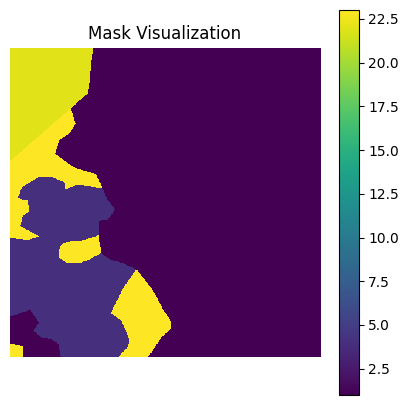

Unique values in the mask: [ 0  1  4 22 23]


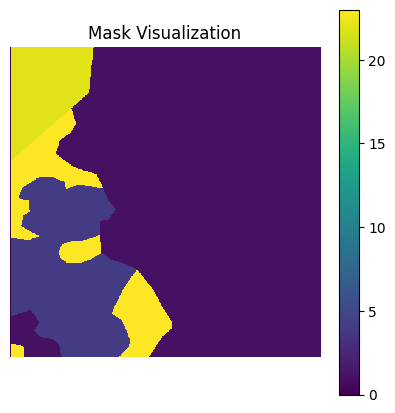

In [10]:
# take look to check
def examine_mask(mask_path):
    mask = np.load(mask_path)
    unique_values = np.unique(mask)
    print(f"Unique values in the mask: {unique_values}")

    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Mask Visualization')
    plt.axis('off')
    plt.show()

# Example usage for the original and 4-band masks
examine_mask("/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format/masks_python_all/SK0667_patch200_lc_2022_detailed_mask.npy")
examine_mask("/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/SK0667_patch200_lc_2022_detailed_mask.npy")


In [ ]:
# lets remove the 0's
def adjust_mask(mask):
    for i in range(mask.shape[0]):  # Loop through each row
        for j in range(mask.shape[1] - 1, -1, -1):  # Start from the rightmost column
            if mask[i, j] == 0 and j < mask.shape[1] - 1:
                mask[i, j] = mask[i, j + 1]  # Replace zero with value from the right
    return mask

# then apply to my new masks
def process_all_masks(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.npy'):
            mask_path = os.path.join(directory, filename)
            mask = np.load(mask_path)

            # Check if there are any zeros and adjust if necessary
            if (mask == 0).any():
                adjusted_mask = adjust_mask(mask)
                np.save(mask_path, adjusted_mask)
                print(f'Adjusted and saved mask: {filename}')
            else:
                print(f'No adjustment needed for: {filename}')

# Directory containing the masks
masks_directory = '/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/'
process_all_masks(masks_directory)

In [28]:
def examine_mask(mask_path):
    # Load the mask
    mask = np.load(mask_path)
    
    # Count the number of zeros
    num_zeros = np.count_nonzero(mask == 0)
    
    # Print out the total number of pixels and the number of zeros
    total_pixels = mask.size
    print(f"Total pixels: {total_pixels}")
    print(f"Number of zeros: {num_zeros}")

# Path to the mask file
mask_path = "/home/david/Documents/ADP/pd_lc_annotated_patches_data/python_format_4band/masks_python_all/SK0667_patch200_lc_2022_detailed_mask.npy"

# Call the function
examine_mask(mask_path)

Total pixels: 262144
Number of zeros: 0


## Loading Model

In [4]:
folder_model = '/home/david/models/'
# file_name = 'main_LCU_2023-04-24-1259_FULL.data'
file_name = 'main_LCU_2023-04-24-1259.pth'

In [5]:
LCU = lcm.load_model_auto(folder=folder_model, filename=file_name)

cross_entropy loss is used.


In [6]:
LCU.dict_training_details

{'class_name_list': ['NO CLASS',
  'Wood and Forest Land',
  'Moor and Heath Land',
  'Agro-Pastoral Land']}

### Loading the train/test patch data set

In [7]:
assert os.path.exists(path_dict['im_patches']), 'Set path of image patches folder (from data repo link above) in datapaths.json' 

tile_patch_train_test_split_dict_path='../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-22-2131.pkl'
if tile_patch_train_test_split_dict_path is not None:
    with open(tile_patch_train_test_split_dict_path, 'rb') as f:
        dict_tile_patches = pickle.load(f)
        tile_patch_train = dict_tile_patches['train']
        tile_patch_test = dict_tile_patches['test']
else:
    tile_patch_train = None
    tile_patch_test = None

mapping_dicts_list = [
          '../content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl',
        '../content/label_mapping_dicts/label_mapping_dict__C_subclasses_only__2023-04-20-1540.pkl',
        '../content/label_mapping_dicts/label_mapping_dict__D_subclasses_only__2023-04-20-1540.pkl',
        '../content/label_mapping_dicts/label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl',
        '../content/label_mapping_dicts/label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl'
                         ]
path_mapping_dict = mapping_dicts_list[3]

train_ds = lcm.DataSetPatches(im_dir=path_dict['im_patches'], mask_dir=None, 
                                mask_suffix='_lc_2022_detailed_mask.npy', 
                                mask_dir_name='masks_python_all',
                                #   list_tile_names=dict_tile_names_sample['train'],
                                list_tile_patches_use=tile_patch_train,
                                preprocessing_func=LCU.preprocessing_func,
                                shuffle_order_patches=True, relabel_masks=True,
                                subsample_patches=False, path_mapping_dict=path_mapping_dict,
                                random_transform_data=False)

No mask directory provided. Will use masks_python_all/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 720).
Patches ordered randomly
Loaded 719 patches
Loaded label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl to map labels


In [8]:
train_ds.class_name_list

['NO CLASS',
 'Cultivated Land',
 'Improved Pasture',
 'Rough Pasture',
 'Wetland, Wet Grassland and Rush Pasture']

In [9]:
for path_mapping_dict in mapping_dicts_list:
    tmp_path_dict = pickle.load(open(path_mapping_dict, 'rb'))
    n_classes = len(tmp_path_dict['dict_new_names'])
    print(path_mapping_dict, n_classes)    

../content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl 14
../content/label_mapping_dicts/label_mapping_dict__C_subclasses_only__2023-04-20-1540.pkl 5
../content/label_mapping_dicts/label_mapping_dict__D_subclasses_only__2023-04-20-1540.pkl 7
../content/label_mapping_dicts/label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl 5
../content/label_mapping_dicts/label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl 4
